# Analyse des sessions

On va s'intéresser dans cette section à l'historique des activités (sessions) des utilisateurs. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

users['found_destination'] = users.apply(lambda r: 'DF' if r['country_destination'] != 'NDF' else 'NDF', axis=1)

On a vu, dans l'introduction, qu'on ne dispose pas des sessions de tous les utilisateurs. De ce fait, on va sélectioner les utilisateurs qui ont une session avant d'équilibrer les classes (DF/NDF).

In [3]:
# Extract user ids who have sessions
base_user_ids = sessions['user_id'].unique()
base_user_ids = base_user_ids.tolist()
base_user_ids.remove(np.nan)

# Remove user ids who are from the test set
test_user_ids = test_users['id'].values
base_user_ids = list(set(base_user_ids) - set(test_user_ids))

# Select sessions with the remaining ids
users_by_ids = users.set_index('id')
session_users = users_by_ids.loc[base_user_ids]

# Balance DF and NDF labels
session_users_ndf = session_users[session_users['found_destination'] == 'NDF'].head(20000)
session_users_df = session_users[session_users['found_destination'] == 'DF'].head(20000)
session_users = pd.concat([session_users_ndf, session_users_df])

sessions = sessions[sessions['user_id'].isin(session_users.index)]
print(f'sessions.shape : {sessions.shape}')
sessions.head()

sessions.shape : (3098239, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


On a 20000 + 20000 utilisateurs DF et NDF.

In [4]:
sessions['found_destination'] = sessions.apply(lambda r: session_users.loc[r['user_id'], 'found_destination'], axis=1)

Affichons le temps que les utilisateurs ont passé sur le site (somme du temps écoulé par activités).

Median NDF : 194.76472222222222 h
Median DF : 328.4058333333333 h


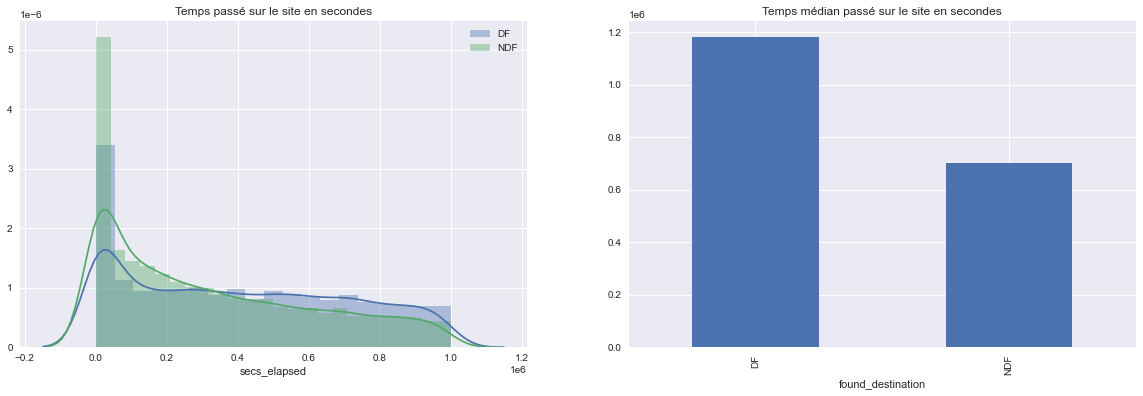

In [22]:
time_elapsed = sessions.groupby(['user_id', 'found_destination'])['secs_elapsed'].sum()
f = plt.figure(figsize=(20, 6))
f.add_subplot(1, 2, 1)
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'DF'], label='DF')
sns.distplot(time_elapsed[time_elapsed < 0.1e7].loc[:,'NDF'], label='NDF')
plt.title("Temps passé sur le site en secondes")
plt.legend()
print(f'Median NDF : {time_elapsed.loc[:, "NDF"].median() / (60**2)} h')
print(f'Median DF : {time_elapsed.loc[:, "DF"].median() / (60**2)} h')

f.add_subplot(1, 2, 2)
time_elapsed.groupby('found_destination').median().plot(kind='bar')
_ = plt.title("Temps médian passé sur le site en secondes")

Les DF passent beaucoup plus de temps sur le site que les NDF, probablement car ils font l'effort de renseigner leur profil, passer du temps sur les différentes annonces, écrire aux hôtes pour poser des questions, etc. Il est possible qu'une partie des NDF ne font que regarder, mais ce ne sont que des suppositions. 

On va étudier les actions effectués par les utilisateurs

In [92]:
sessions.fillna('').groupby(['action', 'action_type', 'action_detail']).count()['user_id'].describe()

count       389.000000
mean       7964.624679
std       32565.151783
min           1.000000
25%          17.000000
50%         222.000000
75%        2245.000000
max      338038.000000
Name: user_id, dtype: float64

On compte près de 389 actions différentes. Une action a été effectuée plus de 300_000 fois, d'autres qu'une seule fois.

In [89]:
# Concat actions
sessions['action_name'] = sessions.fillna('').apply(lambda r: r['action'] + "-" +  r['action_type'] + "-" + r['action_detail'], axis=1)
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed,found_destination,action_name
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0,DF,lookup--
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0,DF,search_results-click-view_search_results
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0,DF,lookup--
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0,DF,search_results-click-view_search_results
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0,DF,lookup--


In [95]:
# Actions that are common among DF / NDF
action_names = sessions.groupby(['user_id', 'found_destination']).agg({'action_name': pd.Series.tolist}).reset_index()
action_names['number_actions'] = action_names.apply(lambda r: r['action_name'].__len__(), axis=1)
action_names.head()

,user_id,found_destination,action_name,number_actions
0,001wyh0pz8,NDF,"[search-click-view_search_results, search-clic...",90
1,002qnbzfs5,DF,[social_connections-data-user_social_connectio...,789
2,0035hobuyj,DF,"[lookup--, search_results-click-view_search_re...",489
3,003iamz20l,NDF,"[active--unknown---unknown-, search-click-view...",163
4,005jc3nbmb,NDF,"[recommended_listings--unknown---unknown-, ask...",26


In [97]:
def count_actions(action, booked):
    action_names['tmp'] = action_names.apply(lambda r: 1 if action in r['action_name'] else 0, axis=1)
    res = action_names.groupby('found_destination').agg({'tmp': sum}).loc[booked]
    return res

# Actions that are the most common among DF
action_names_stats_df = pd.DataFrame()
action_names_stats_df['action_name'] = sessions.action_name.unique()
action_names_stats_df['count'] = action_names_stats_df.apply(lambda r: count_actions(r['action_name'], 'DF'), axis=1)

# Actions that are the most common among NDF
action_names_stats_ndf = pd.DataFrame()
action_names_stats_ndf['action_name'] = sessions.action_name.unique()
action_names_stats_ndf['count'] = action_names_stats_ndf.apply(lambda r: count_actions(r['action_name'], 'NDF'), axis=1)

# Combine DF and NDF
action_names_stats = pd.DataFrame()
action_names_stats['action_name'] = sessions['action_name'].unique()
action_names_stats['count_df'] = action_names_stats_df['count'].values
action_names_stats['count_ndf'] = action_names_stats_ndf['count'].values
action_names_stats['diff'] = (action_names_stats['count_df'] - action_names_stats['count_ndf']) / (action_names_stats['count_df'] + action_names_stats['count_ndf'])

Combinaisons d'actions propres aux DF : 
['requested-submit-post_checkout_action', 'pending-booking_request-pending', 'requested-view-p5', 'agree_terms_check--unknown---unknown-', 'message_to_host_change-click-message_to_host_change', 'qt_with-data-lookup_message_thread', 'at_checkpoint-booking_request-at_checkpoint', 'message_to_host_focus-click-message_to_host_focus', 'ajax_photo_widget_form_iframe--unknown---unknown-', 'complete_redirect--unknown---unknown-']
Combinaisons d'actions propres aux NDF : 
['campaigns--', 'update-submit-update_user', 'search-click-view_search_results', 'domains--unknown---unknown-', 'create-submit-signup', 'create-view-list_your_space', 'index-view-listing_descriptions', 'update-submit-update_listing_description', 'manage_listing-view-manage_listing', 'set_user-submit-create_listing']


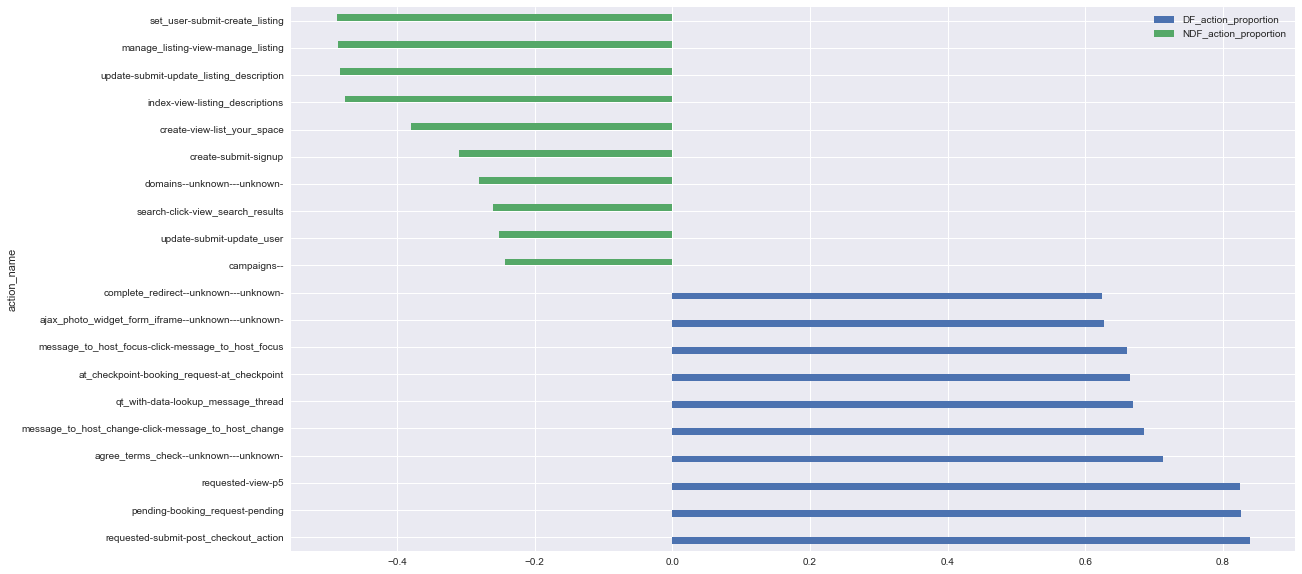

In [135]:
n_top = 10
ndf_actions_names_stats = action_names_stats[action_names_stats['count_df'] + action_names_stats['count_ndf'] > 500].sort_values(by='diff').head(n_top).sort_values(by='diff', ascending=False).reset_index()
df_actions_names_stats = action_names_stats[action_names_stats['count_df'] + action_names_stats['count_ndf'] > 500].sort_values(by='diff').tail(n_top).sort_values(by='diff', ascending=False).reset_index()
names_stats = pd.DataFrame({
    'action_name': df_actions_names_stats['action_name'].values.tolist() + ndf_actions_names_stats['action_name'].values.tolist(),
    'DF_action_proportion': df_actions_names_stats['diff'].values.tolist() +  [0 for _ in range(ndf_actions_names_stats.shape[0])],
    'NDF_action_proportion': [0 for _ in range(df_actions_names_stats.shape[0])] + ndf_actions_names_stats['diff'].values.tolist(),
})
names_stats.set_index('action_name').plot.barh(figsize=(18, 10))
print(f"Combinaisons d'actions propres aux DF : \n{df_actions_names_stats['action_name'].values.tolist()}")
print(f"Combinaisons d'actions propres aux NDF : \n{ndf_actions_names_stats['action_name'].values.tolist()}")

Ici, on vient d'afficher, les 10 actions les plus fréquents chez les NDF et chez les DF en ordonnée. La fréquence d'une action est calculée selon la différence d'apparition chez les DF et les NDF divisée par le nombre total d'apparition au sein des utilisateurs. Plus cette valeur est proche de +1, plus cette action est propre aux DF. Plus cette valeur est proche de -1, plus cette action est propre aux NDF. On ne garde uniquement les actions qui ont été effectuées par au moins 500 utilisateurs.

On voit sur le graphique que les DF ont une forte tendance à effectuer les actions liées aux réservations : soumettre la requête de réservation ("requested"), mis en attente ("pending"), "agree_terms_check", communiquer avec l'hôte ("message_to_host_change", 'message_to_host_focus")...

Les actions relatives au terme "listing" renvoient au processus de création ou mise à jour d'une page d'un logement. Ce sont donc des actions liées aux hôtes qui louent leur logement. C'est ce qu'on voit dans les actions les plus effectuées parmi les NDF : "manage_listing" et "set_user-submit-create_listing". Ainsi, une portion des NDF sont des hôtes.